
# Metrics

## Data

### Close value

In [1]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn, DeviationSource, DeviationScale
from metrics.utils import MetricLevel, print_relation_results

company_name = "Adobe"
time_series_start = "2017-01-03"
time_series_values = 300
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                          weights={SeriesColumn.OPEN: 0.2,
                                   SeriesColumn.CLOSE: 0.2,
                                   SeriesColumn.ADJ_CLOSE: 0.25,
                                   SeriesColumn.HIGH: 0.15,
                                   SeriesColumn.LOW: 0.15,
                                   SeriesColumn.VOLUME: 0.05},
                          all_noises_strength={DeviationScale.SLIGHTLY: 0.7,
                                               DeviationScale.MODERATELY: 3.0,
                                               DeviationScale.HIGHLY: 7.0},
                          all_incomplete_parts={DeviationScale.SLIGHTLY: 0.05,
                                                DeviationScale.MODERATELY: 0.12,
                                                DeviationScale.HIGHLY: 0.3},
                          partially_noised_strength={SeriesColumn.CLOSE: {DeviationScale.SLIGHTLY: 0.6,
                                                                          DeviationScale.MODERATELY: 2.0,
                                                                          DeviationScale.HIGHLY: 6.0},
                                                     SeriesColumn.OPEN: {DeviationScale.SLIGHTLY: 0.4,
                                                                         DeviationScale.MODERATELY: 1.7,
                                                                         DeviationScale.HIGHLY: 5.2}},
                          partially_incomplete_parts={SeriesColumn.CLOSE: {DeviationScale.SLIGHTLY: 0.05,
                                                                           DeviationScale.MODERATELY: 0.12,
                                                                           DeviationScale.HIGHLY: 0.3},
                                                      SeriesColumn.OPEN: {DeviationScale.SLIGHTLY: 0.05,
                                                                          DeviationScale.MODERATELY: 0.12,
                                                                          DeviationScale.HIGHLY: 0.3}})

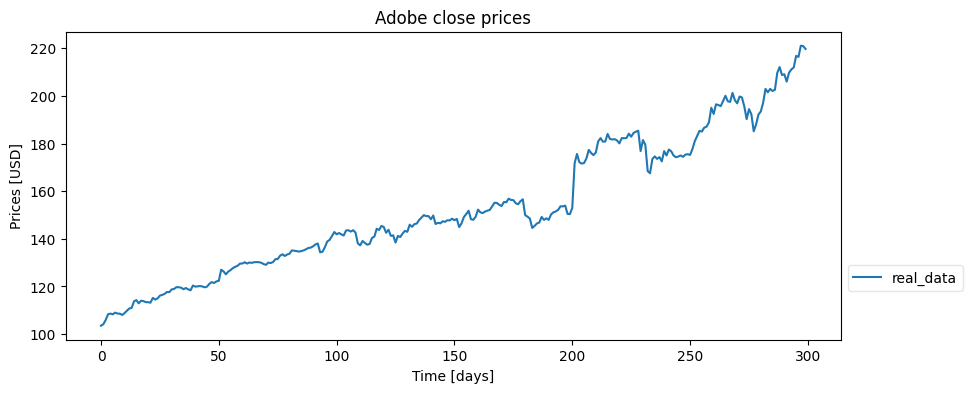

In [2]:
stock.plot_series("close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

### Other values

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier


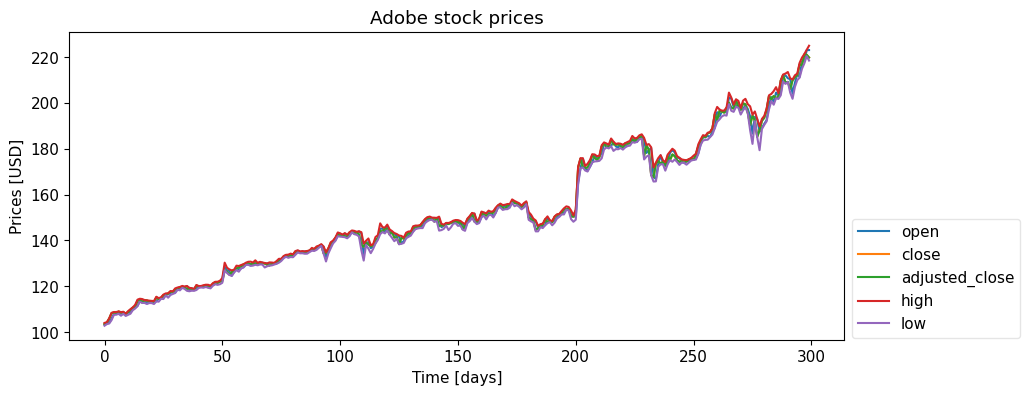

In [3]:
stock.plot_series("stock prices",
                  open=stock.real_series[SeriesColumn.OPEN],
                  close=stock.real_series[SeriesColumn.CLOSE],
                  adjusted_close=stock.real_series[SeriesColumn.ADJ_CLOSE],
                  high=stock.real_series[SeriesColumn.HIGH],
                  low=stock.real_series[SeriesColumn.LOW])

## Correctness metric

### Show noise

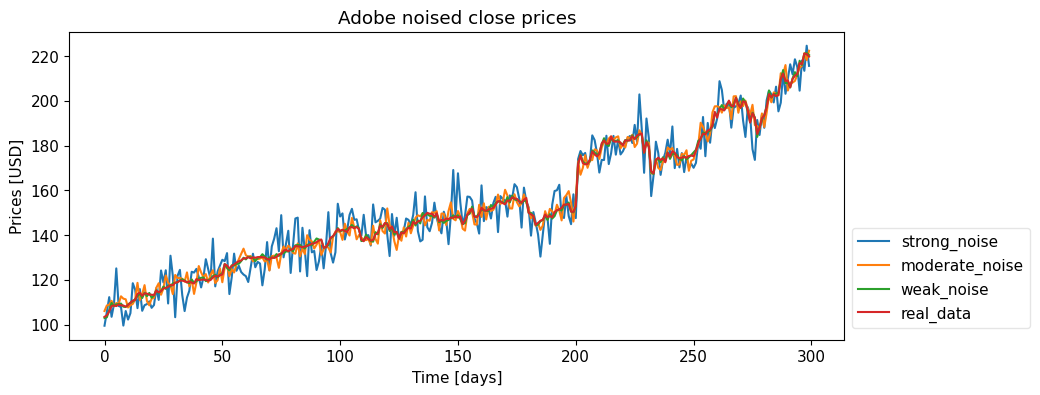

In [4]:
stock.plot_series("noised close prices",
                  strong_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.HIGHLY][
                      SeriesColumn.CLOSE],
                  moderate_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.MODERATELY][
                      SeriesColumn.CLOSE],
                  weak_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.SLIGHTLY][
                      SeriesColumn.CLOSE],
                  real_data=stock.real_series[SeriesColumn.CLOSE])

### Show Kalman filter

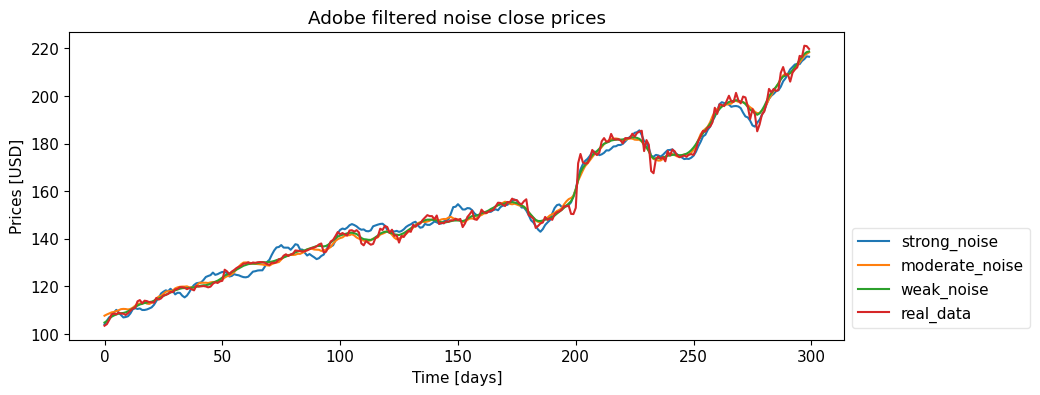

In [5]:
stock.plot_series("filtered noise close prices",
                  strong_noise=stock.mitigated_deviations_series[DeviationSource.NOISE][DeviationScale.HIGHLY][
                      SeriesColumn.CLOSE],
                  moderate_noise=stock.mitigated_deviations_series[DeviationSource.NOISE][DeviationScale.MODERATELY][
                      SeriesColumn.CLOSE],
                  weak_noise=stock.mitigated_deviations_series[DeviationSource.NOISE][DeviationScale.SLIGHTLY][
                      SeriesColumn.CLOSE],
                  real_data=stock.real_series[SeriesColumn.CLOSE])

### Heinrich's correctness metric on values

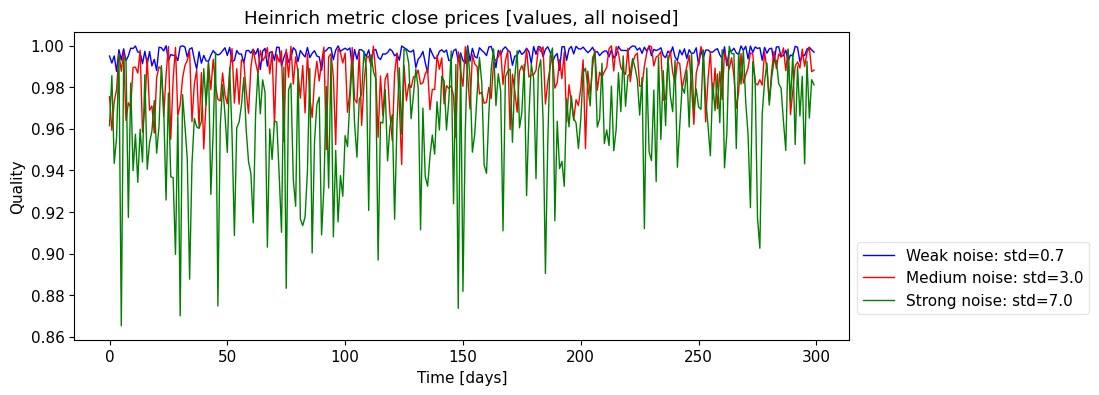

In [6]:
from correctness import HeinrichCorrectnessMetric
from timeseries.utils import DeviationRange

heinrich = HeinrichCorrectnessMetric(stock,
                                     alpha={SeriesColumn.OPEN: 1.6,
                                            SeriesColumn.CLOSE: 2.1,
                                            SeriesColumn.ADJ_CLOSE: 1.7,
                                            SeriesColumn.HIGH: 2.0,
                                            SeriesColumn.LOW: 2.3,
                                            SeriesColumn.VOLUME: 3.1})

qualities = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=False,
                                 column_name=SeriesColumn.CLOSE)

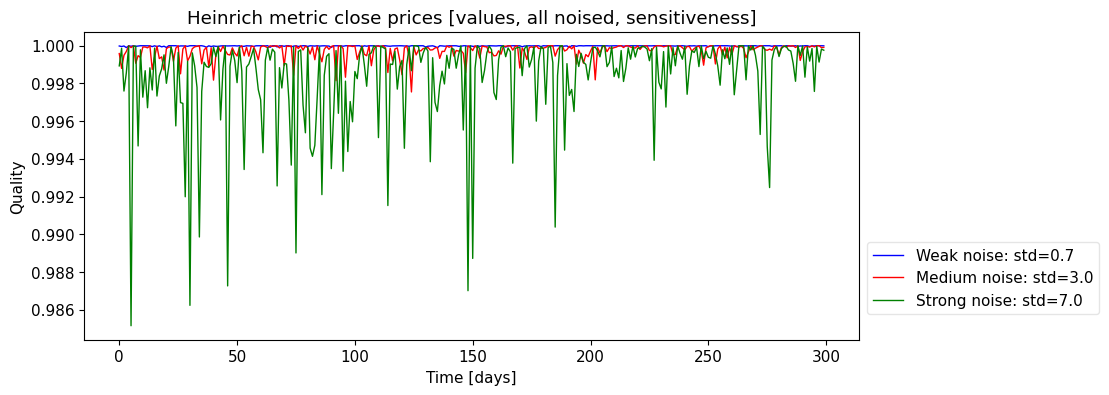

In [7]:
qualities = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=True)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=True,
                                 column_name=SeriesColumn.CLOSE)

### Heinrich's correctness metric on tuples - all fields noised

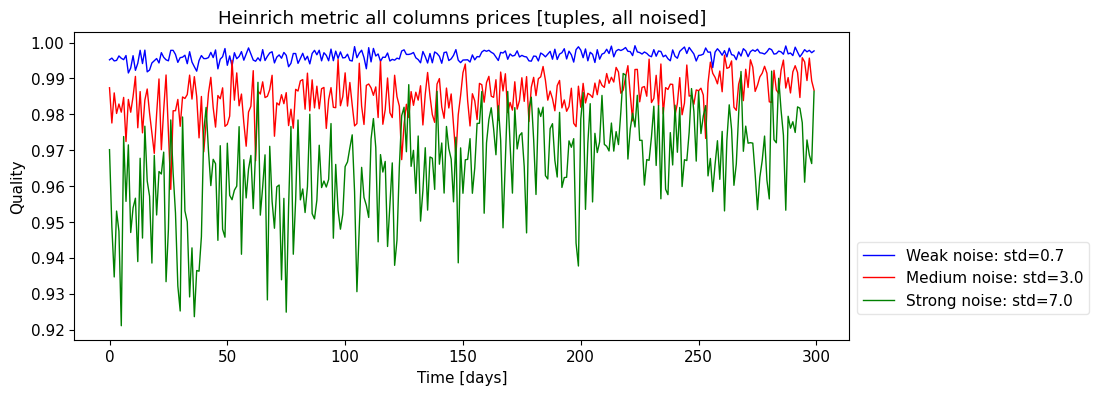

In [8]:
qualities = heinrich.tuples_qualities(DeviationRange.ALL, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.TUPLES, is_alpha=False, noise_range=DeviationRange.ALL)

### Heinrich's correctness metric on tuples - some fields noised

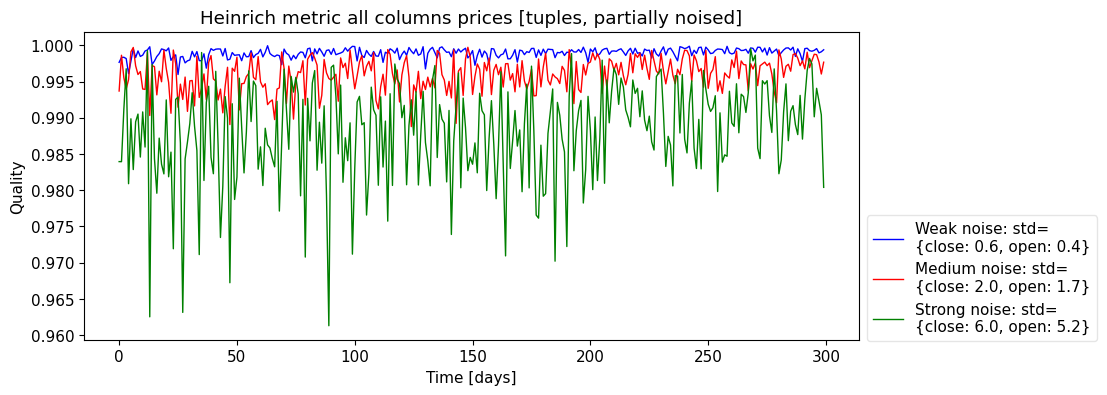

In [9]:
qualities = heinrich.tuples_qualities(DeviationRange.PARTIAL, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.TUPLES, is_alpha=False, noise_range=DeviationRange.PARTIAL)

### Heinrich's correctness metric on relation

In [10]:
qualities = heinrich.relation_qualities(is_alpha=False)
print_relation_results(qualities, DeviationSource.NOISE, DeviationRange.ALL)

Relation quality differences due to different noise levels of all fields:
Data slightly deviated: 0.996352625437698
Data moderately deviated: 0.9851390847380456
Data highly deviated: 0.9651927419820883


In [11]:
qualities = heinrich.relation_qualities(DeviationRange.PARTIAL, is_alpha=False)
print_relation_results(qualities, DeviationSource.NOISE, DeviationRange.PARTIAL)

Relation quality differences due to different noise levels of some fields:
Data slightly deviated: 0.9989462908556309
Data moderately deviated: 0.9959831541018609
Data highly deviated: 0.9881287843514546


## Completeness metrics

### Show incompleteness

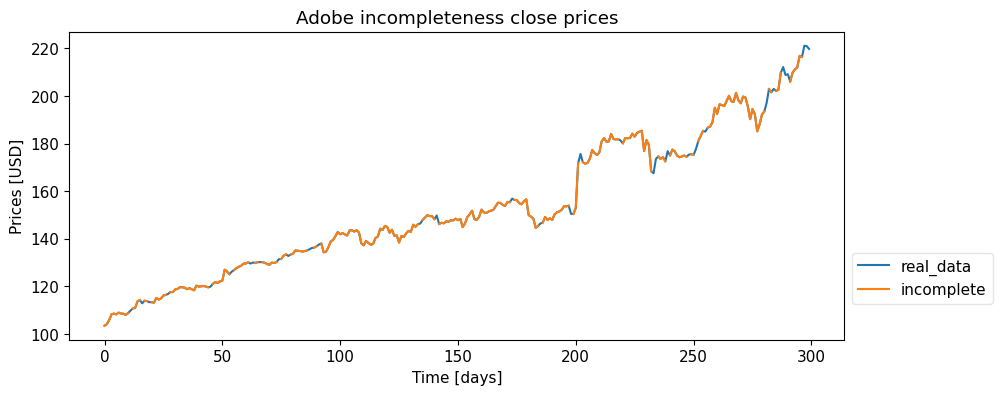

In [12]:
stock.plot_series("incompleteness close prices",
                  real_data=stock.real_series[SeriesColumn.CLOSE],
                  incomplete=stock.all_deviated_series[DeviationSource.INCOMPLETENESS]
                  [DeviationScale.MODERATELY][SeriesColumn.CLOSE])

### Show interpolated values

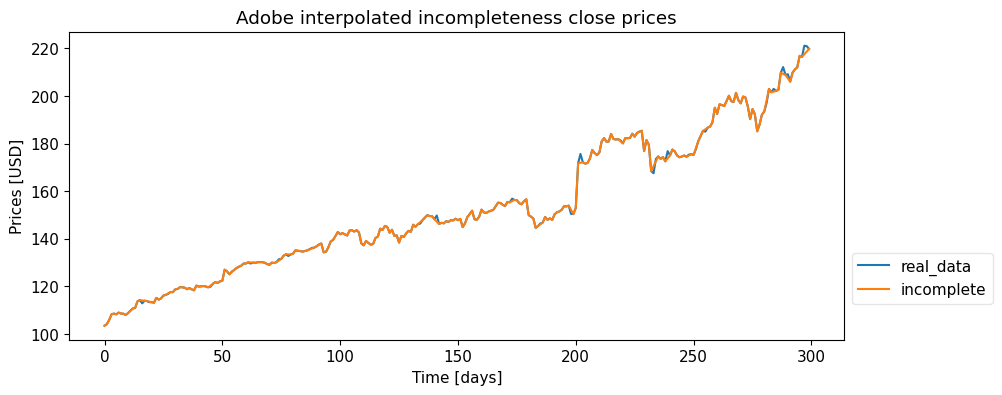

In [13]:
stock.plot_series("interpolated incompleteness close prices",
                  real_data=stock.real_series[SeriesColumn.CLOSE],
                  incomplete=stock.mitigated_deviations_series[DeviationSource.INCOMPLETENESS]
                  [DeviationScale.MODERATELY][SeriesColumn.CLOSE])

### Blake's completeness metric on values

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier


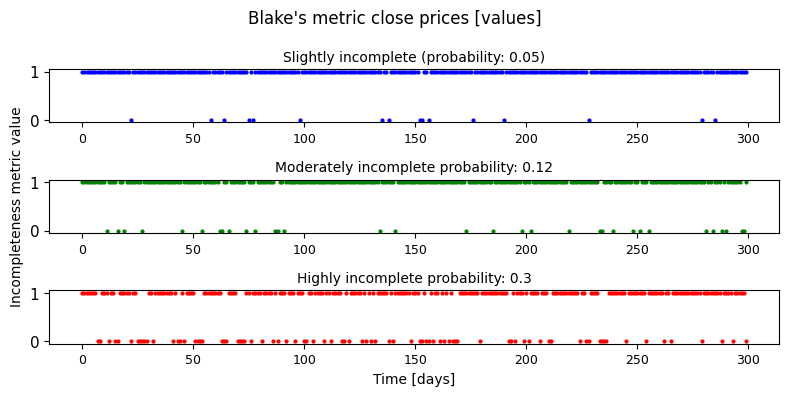

In [14]:
from metrics.completeness import BlakeCompletenessMetric

blake = BlakeCompletenessMetric(stock)
qualities = blake.values_qualities(SeriesColumn.CLOSE)
blake.draw_blake(qualities, MetricLevel.VALUES, column_name=SeriesColumn.CLOSE)

### Blake's completeness metric on tuples - all columns affected

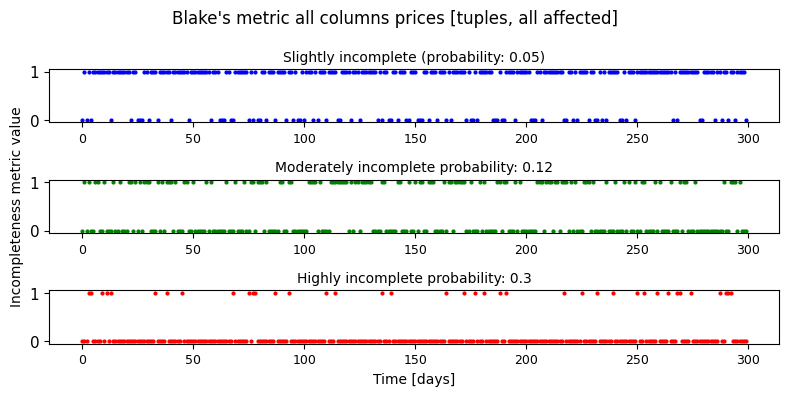

In [15]:
qualities = blake.tuples_qualities(incompleteness_range=DeviationRange.ALL)
blake.draw_blake(qualities, MetricLevel.TUPLES, incompleteness_range=DeviationRange.ALL)

### Blake's completeness metric on tuples - some columns affected

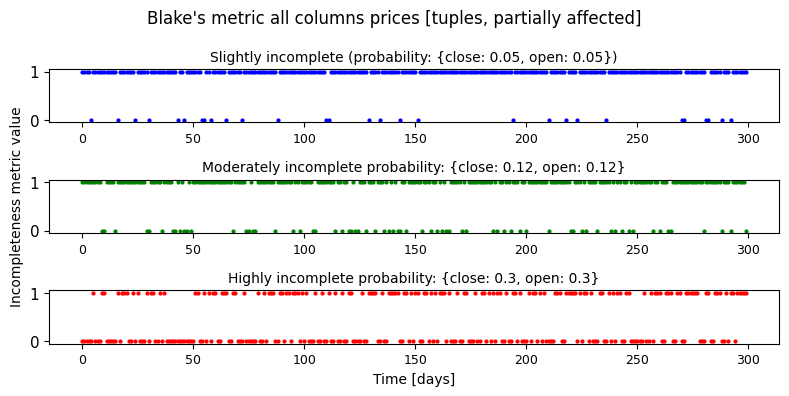

In [16]:
qualities = blake.tuples_qualities(incompleteness_range=DeviationRange.PARTIAL)
blake.draw_blake(qualities, MetricLevel.TUPLES, incompleteness_range=DeviationRange.PARTIAL)

### Blake's completeness metric on relation

In [17]:
qualities = blake.relation_qualities(incompleteness_range=DeviationRange.ALL)
print_relation_results(qualities, DeviationSource.INCOMPLETENESS, DeviationRange.ALL)

Relation quality differences due to different incompleteness levels of all fields:
Data slightly deviated: 0.7133333333333334
Data moderately deviated: 0.41000000000000003
Data highly deviated: 0.13


In [18]:
qualities = blake.relation_qualities(incompleteness_range=DeviationRange.PARTIAL)
print_relation_results(qualities, DeviationSource.INCOMPLETENESS, DeviationRange.PARTIAL)

Relation quality differences due to different incompleteness levels of some fields:
Data slightly deviated: 0.9033333333333333
Data moderately deviated: 0.77
Data highly deviated: 0.4633333333333334


## Timeliness metric

### Timeliness metric on values

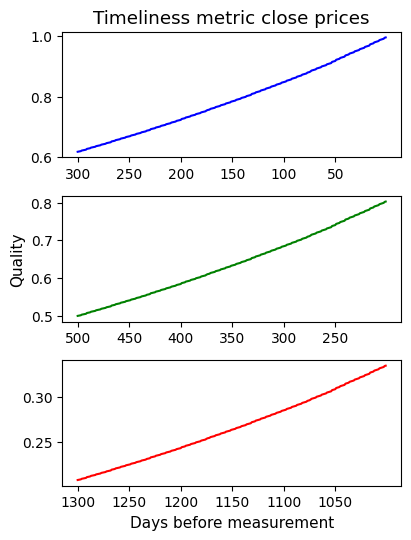

In [19]:
from metrics.timeliness import HeinrichTimelinessMetric

declines = {SeriesColumn.OPEN: 0.4,
            SeriesColumn.CLOSE: 0.4,
            SeriesColumn.ADJ_CLOSE: 0.3,
            SeriesColumn.HIGH: 0.4,
            SeriesColumn.LOW: 0.4,
            SeriesColumn.VOLUME: 0.7}

measurement_times = {DeviationScale.SLIGHTLY: 5,
                     DeviationScale.MODERATELY: 200,
                     DeviationScale.HIGHLY: 1000}

timeliness = HeinrichTimelinessMetric(stock)
time_deltas, qualities = timeliness.values_qualities(declines[SeriesColumn.CLOSE], measurement_times)
timeliness.draw_timeliness_qualities(time_deltas, qualities, SeriesColumn.CLOSE)

### Timeliness metric on tuples

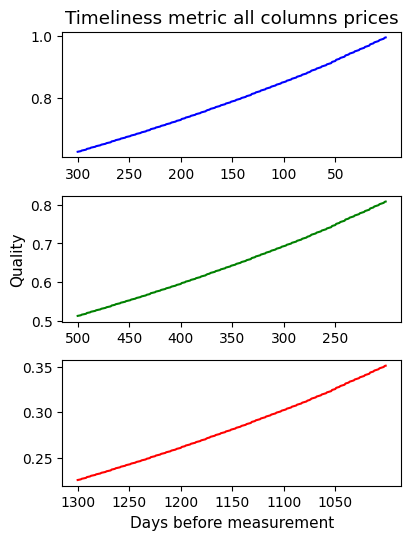

In [20]:
time_deltas, qualities = timeliness.tuples_qualities(declines, measurement_times)
timeliness.draw_timeliness_qualities(time_deltas, qualities)

### Timeliness metric on relation

In [21]:
qualities = timeliness.relation_qualities(declines, measurement_times)
print_relation_results(qualities, DeviationSource.TIMELINESS, DeviationRange.ALL)

Relation quality differences due to different obsolescence levels of all fields:
Data slightly deviated: 0.7961923796110164
Data moderately deviated: 0.6482589483012084
Data highly deviated: 0.2833211335660943
